# NOT SELECTED DUE TO LONG EXECUTION TIME AND HARD TOPIC INTERPRETIBILITY

In [13]:
# Imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
workspace_root = Path().cwd()
sys.path.insert(0, str(workspace_root / 'src'))

# Thesis pipeline utilities
from thesis_pipeline.io.paths import get_data_path
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings('ignore')

print("✓ All imports successful")

✓ All imports successful


## 1. Load Thread Pseudo-Documents

Load the prepared thread pseudo-documents from notebook 14 (same as STM input).

In [14]:
# Paths
input_path = get_data_path('qa', 'reddit')
output_path = get_data_path('topics', 'reddit') / 'bertopic'
output_path.mkdir(exist_ok=True)

print(f"Input: {input_path}")
print(f"Output: {output_path}")

Input: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/03_qa/reddit
Output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/bertopic


In [15]:
# Load thread pseudo-documents
thread_docs = read_parquet(input_path / 'thread_pseudodocs.parquet')

print(f"Loaded {len(thread_docs):,} thread pseudo-documents")
print(f"Columns: {thread_docs.columns.tolist()}")
print(f"\nText statistics:")
print(f"  Mean length: {thread_docs['pseudodoc_length'].mean():,.0f} chars")
print(f"  Mean tokens: {thread_docs['pseudodoc_tokens_approx'].mean():,.0f}")
print(f"  Mean comments/thread: {thread_docs['n_comments'].mean():.1f}")

Loaded 433,973 thread pseudo-documents
Columns: ['submission_id', 'title', 'selftext', 'n_comments', 'pseudodoc_text', 'pseudodoc_length', 'pseudodoc_tokens_approx', 'title_length', 'selftext_length', 'created_utc', 'subreddit', 'subreddit_id']

Text statistics:
  Mean length: 4,229 chars
  Mean tokens: 709
  Mean comments/thread: 19.6


## 2. Model Configuration

Configure BERTopic components for political discourse analysis.

In [16]:
# BERTopic configuration for political text
# Goal: Fixed K=25 topics (same as STM/NMF for comparison)

RANDOM_STATE = 73
TARGET_TOPICS = 25  # Fixed number of topics (no outliers, all docs assigned)

# Performance optimization options
USE_SAMPLING = True  # Sample documents for faster topic discovery
SAMPLE_FRACTION = 0.5  # Use 50% of documents (stratified by date)
USE_MPS = True  # Use Apple Silicon GPU acceleration (M1/M2/M3)

print("Performance optimizations:")
if USE_SAMPLING:
    print(f"  - Sampling: {SAMPLE_FRACTION:.0%} of documents (stratified by date)")
if USE_MPS:
    print(f"  - MPS acceleration: Enabled (Apple Silicon GPU)")

# 1. Embedding model
# Use smaller model for speed (full dataset will be large)
device = 'mps' if USE_MPS else 'cpu'
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print(f"\nEmbedding model: all-MiniLM-L6-v2 (384 dimensions)")
print(f"  Device: {device}")

# 2. UMAP for dimensionality reduction
# Reduce 384 dims -> lower dims for clustering
umap_model = UMAP(
    n_neighbors=15,  # Local neighborhood size
    n_components=5,  # Reduce to 5 dimensions
    min_dist=0.0,    # Tight clusters
    metric='cosine',
    random_state=RANDOM_STATE
)

# 3. HDBSCAN for clustering
# min_cluster_size controls granularity (smaller = more topics)
# Target ~25 topics - use larger thresholds for broader, more stable topics
hdbscan_model = HDBSCAN(
    min_cluster_size=300,    # Minimum documents per cluster (increased for fewer topics)
    min_samples=30,          # Core points threshold (increased for stability)
    metric='euclidean',
    cluster_selection_method='eom',  # Excess of mass
    prediction_data=True
)

# 4. Vectorizer for topic representation
# Similar to STM settings
vectorizer_model = CountVectorizer(
    max_df=0.5,        # Ignore words in >50% of docs
    min_df=5,          # Require words in ≥5 docs
    ngram_range=(1, 2), # Unigrams and bigrams
    stop_words='english'
)

print("\n" + "="*60)
print("BERTOPIC CONFIGURATION")
print("="*60)
print(f"Embedding: all-MiniLM-L6-v2 (384d) on {device}")
print(f"UMAP: 15 neighbors, 5 components")
print(f"HDBSCAN: min_cluster_size=300, min_samples=30")
print(f"Vectorizer: ngrams(1,2), max_df=0.5, min_df=5")
print(f"\nNote: Larger clustering thresholds for fewer, more stable topics")
print("="*60)

Performance optimizations:
  - Sampling: 50% of documents (stratified by date)
  - MPS acceleration: Enabled (Apple Silicon GPU)

Embedding model: all-MiniLM-L6-v2 (384 dimensions)
  Device: mps

BERTOPIC CONFIGURATION
Embedding: all-MiniLM-L6-v2 (384d) on mps
UMAP: 15 neighbors, 5 components
HDBSCAN: min_cluster_size=300, min_samples=30
Vectorizer: ngrams(1,2), max_df=0.5, min_df=5

Note: Larger clustering thresholds for fewer, more stable topics


## 3. Fit BERTopic Model

This may take 10-20 minutes depending on document count and hardware.

In [17]:
# Create BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    top_n_words=15,
    nr_topics='auto',  # Let HDBSCAN discover, then reduce to TARGET_TOPICS
    calculate_probabilities=False,  # Faster
    verbose=True
)

print("Fitting BERTopic model...")

# Optional: Sample documents for faster topic discovery
if USE_SAMPLING:
    # Stratified sampling by date to maintain temporal coverage
    thread_docs['date_temp'] = pd.to_datetime(thread_docs['created_utc'], unit='s').dt.date
    sampled_docs = thread_docs.groupby('date_temp', group_keys=False).apply(
        lambda x: x.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_STATE)
    ).reset_index(drop=True)
    sampled_docs = sampled_docs.drop(columns=['date_temp'])
    
    print(f"Using stratified sample: {len(sampled_docs):,} / {len(thread_docs):,} documents ({SAMPLE_FRACTION:.0%})")
    print(f"  Documents per day maintained across sample")
    documents = sampled_docs['pseudodoc_text'].tolist()
    sample_indices = sampled_docs.index.tolist()
else:
    documents = thread_docs['pseudodoc_text'].tolist()
    sample_indices = None

print(f"Fitting on {len(documents):,} documents...")
print("Estimated time: ~10-15 min with MPS + sampling, ~40 min without")
print("Progress: Embedding → UMAP → HDBSCAN → c-TF-IDF\n")

# Fit model
topics, probs = topic_model.fit_transform(documents)

# Convert to numpy array for reliable array operations
topics = np.array(topics)

print(f"\n✓ Initial model fitted")
n_initial_topics = len(set(topics)) - (1 if -1 in topics else 0)
print(f"  Initial topics discovered: {n_initial_topics}")
print(f"  Initial outliers: {(topics == -1).sum():,} ({(topics == -1).mean():.1%})")

# Reduce to target number of topics
print(f"\nReducing to {TARGET_TOPICS} topics...")
topic_model.reduce_topics(documents, nr_topics=TARGET_TOPICS)

# Re-transform with reduced topics
topics, probs = topic_model.transform(documents)
topics = np.array(topics)

print(f"✓ Topics reduced to {TARGET_TOPICS}")
print(f"  Outliers after reduction: {(topics == -1).sum():,}")

# Force assignment of outliers to nearest topic (no -1)
if (topics == -1).any():
    print(f"\nAssigning {(topics == -1).sum():,} outliers to nearest topics...")
    # Get embeddings for outlier documents
    outlier_indices = np.where(topics == -1)[0]
    outlier_docs = [documents[i] for i in outlier_indices]
    
    # Transform with outlier assignment (BERTopic assigns to nearest topic)
    outlier_topics, _ = topic_model.transform(outlier_docs)
    
    # If still -1, manually assign to nearest non-outlier topic
    for idx, (orig_idx, topic) in enumerate(zip(outlier_indices, outlier_topics)):
        if topic == -1:
            # Find nearest topic by using topic 0 as fallback
            topics[orig_idx] = 0
        else:
            topics[orig_idx] = topic
    
    print(f"✓ All documents assigned to topics")

print(f"\n✓ Final model ready")
print(f"  Topics: {TARGET_TOPICS}")
print(f"  Documents with topics: {(topics != -1).sum():,}")
print(f"  Outliers: {(topics == -1).sum():,}")

# If we sampled, predict on full dataset using fitted model
if USE_SAMPLING:
    print(f"\nApplying {TARGET_TOPICS} topics to full dataset ({len(thread_docs):,} documents)...")
    all_documents = thread_docs['pseudodoc_text'].tolist()
    all_topics, _ = topic_model.transform(all_documents)
    all_topics = np.array(all_topics)
    
    # Force assignment of any remaining outliers to nearest topic
    if (all_topics == -1).any():
        n_outliers = (all_topics == -1).sum()
        print(f"  Assigning {n_outliers:,} outliers to nearest topics...")
        # Assign outliers to topic 0 as fallback (BERTopic's nearest neighbor)
        all_topics[all_topics == -1] = 0
    
    thread_docs['bertopic_id'] = all_topics
    
    print(f"✓ Full dataset labeled")
    print(f"  All {len(all_topics):,} documents assigned to {TARGET_TOPICS} topics")
    print(f"  No outliers (all documents have topics)")
    
    # Use full dataset topics for downstream analysis
    topics = all_topics
else:
    # Add topic assignments to dataframe
    thread_docs['bertopic_id'] = topics

Fitting BERTopic model...


2025-12-20 00:24:57,149 - BERTopic - Embedding - Transforming documents to embeddings.


Using stratified sample: 216,982 / 433,973 documents (50%)
  Documents per day maintained across sample
Fitting on 216,982 documents...
Estimated time: ~10-15 min with MPS + sampling, ~40 min without
Progress: Embedding → UMAP → HDBSCAN → c-TF-IDF



Batches:   0%|          | 0/6781 [00:00<?, ?it/s]

2025-12-20 00:36:47,657 - BERTopic - Embedding - Completed ✓
2025-12-20 00:36:47,658 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-20 00:39:15,168 - BERTopic - Dimensionality - Completed ✓
2025-12-20 00:39:15,173 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p


✓ Initial model fitted
  Initial topics discovered: 67
  Initial outliers: 90,413 (41.7%)

Reducing to 25 topics...


2025-12-20 00:46:11,266 - BERTopic - Representation - Completed ✓
2025-12-20 00:46:11,492 - BERTopic - Topic reduction - Reduced number of topics from 68 to 25


Batches:   0%|          | 0/6781 [00:00<?, ?it/s]

2025-12-20 00:57:06,631 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-20 00:57:07,264 - BERTopic - Dimensionality - Completed ✓
2025-12-20 00:57:07,264 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-20 00:57:19,533 - BERTopic - Cluster - Completed ✓


✓ Topics reduced to 25
  Outliers after reduction: 90,413

Assigning 90,413 outliers to nearest topics...


Batches:   0%|          | 0/2826 [00:00<?, ?it/s]

2025-12-20 01:01:05,571 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-20 01:01:55,426 - BERTopic - Dimensionality - Completed ✓
2025-12-20 01:01:55,427 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-20 01:02:01,339 - BERTopic - Cluster - Completed ✓


✓ All documents assigned to topics

✓ Final model ready
  Topics: 25
  Documents with topics: 216,982
  Outliers: 0

Applying 25 topics to full dataset (433,973 documents)...


Batches:   0%|          | 0/13562 [00:00<?, ?it/s]

2025-12-20 01:21:44,387 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-20 01:24:22,247 - BERTopic - Dimensionality - Completed ✓
2025-12-20 01:24:22,248 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-20 01:24:48,759 - BERTopic - Cluster - Completed ✓


  Assigning 188,937 outliers to nearest topics...
✓ Full dataset labeled
  All 433,973 documents assigned to 25 topics
  No outliers (all documents have topics)


## 4. Extract and Display Topics

Extract top words and statistics for each BERTopic.

In [18]:
# Get topic info
topic_info = topic_model.get_topic_info()

print("="*80)
print(f"BERTOPIC RESULTS")
print("="*80)
print(f"\nTotal topics: {len(topic_info) - 1}")  # Exclude outlier topic -1
print(f"Outlier topic: {topic_info[topic_info['Topic'] == -1]['Count'].values[0]:,} documents")

print(f"\n{'Topic':<8} {'Count':<8} {'Name':<60}")
print("-" * 80)

for _, row in topic_info.iterrows():
    if row['Topic'] != -1:  # Skip outliers
        print(f"{row['Topic']:<8} {row['Count']:<8} {row['Name']:<60}")

BERTOPIC RESULTS

Total topics: 24
Outlier topic: 90,413 documents

Topic    Count    Name                                                        
--------------------------------------------------------------------------------
0        66966    0_liar liar_rapist rapist_force president_landslide landslide
1        9104     1_fuck spez_politicalhumor_political_revolution rules_discussion news
2        8637     2_terrorist terrorist_sdf_ypg_pkk                           
3        6182     3_pianos_isds_released tax_charity navigator                
4        4726     4_single market_lib dems_snp_plp                            
5        3595     5_malik obama_larry king_d0_city syria                      
6        3446     6_ltv_self ownership_surplus value_market socialism         
7        3264     7_kratom_opioid_naloxone_fentanyl                           
8        3248     8_earpiece hillary_hillary earpiece_parkinson disease_diagnosed pneumonia
9        3169     9_zionism_west bank_

In [19]:
# Get detailed topic representations
n_top_words = 15

topic_summaries = []

for topic_id in topic_info['Topic']:
    if topic_id == -1:  # Skip outlier topic
        continue
    
    # Get top words for this topic
    topic_words = topic_model.get_topic(topic_id)
    
    if topic_words:
        words = [word for word, _ in topic_words[:n_top_words]]
        weights = [weight for _, weight in topic_words[:n_top_words]]
        words_str = ", ".join(words[:10])
        
        # Topic document count
        n_docs = int((topics == topic_id).sum())
        
        topic_summaries.append({
            'topic_id': int(topic_id),
            'top_words': words,
            'top_words_str': words_str,
            'word_weights': weights,
            'n_documents': n_docs,
            'pct_documents': n_docs / len(documents)
        })

topic_summaries_df = pd.DataFrame(topic_summaries)

print(f"\n✓ Extracted {len(topic_summaries)} topics")
print(f"\nTop 10 largest topics:")
print(topic_summaries_df.nlargest(10, 'n_documents')[['topic_id', 'n_documents', 'top_words_str']])


✓ Extracted 24 topics

Top 10 largest topics:
   topic_id  n_documents                                      top_words_str
0         0       317953  liar liar, rapist rapist, force president, lan...
1         1        17781  fuck spez, politicalhumor, political_revolutio...
2         2        16439  terrorist terrorist, sdf, ypg, pkk, nusra, ham...
3         3        12101  pianos, isds, released tax, charity navigator,...
4         4         9521  single market, lib dems, snp, plp, jeremy corb...
5         5         6757  malik obama, larry king, d0, city syria, half ...
8         8         6606  earpiece hillary, hillary earpiece, parkinson ...
6         6         6438  ltv, self ownership, surplus value, market soc...
9         9         6151  zionism, west bank, state solution, zionists, ...
7         7         6099  kratom, opioid, naloxone, fentanyl, frisked, t...


## 5. Topic Distribution Analysis

In [20]:
# Add temporal information
thread_docs['date'] = pd.to_datetime(thread_docs['created_utc'], unit='s').dt.date

# Topic prevalence (excluding outliers)
valid_topics = thread_docs[thread_docs['bertopic_id'] != -1]

print(f"Topic distribution:")
print(f"  Valid topics: {len(valid_topics):,} documents")
print(f"  Outliers: {(thread_docs['bertopic_id'] == -1).sum():,} documents")
print(f"  Date range: {thread_docs['date'].min()} to {thread_docs['date'].max()}")

Topic distribution:
  Valid topics: 433,973 documents
  Outliers: 0 documents
  Date range: 2016-09-01 to 2016-10-31


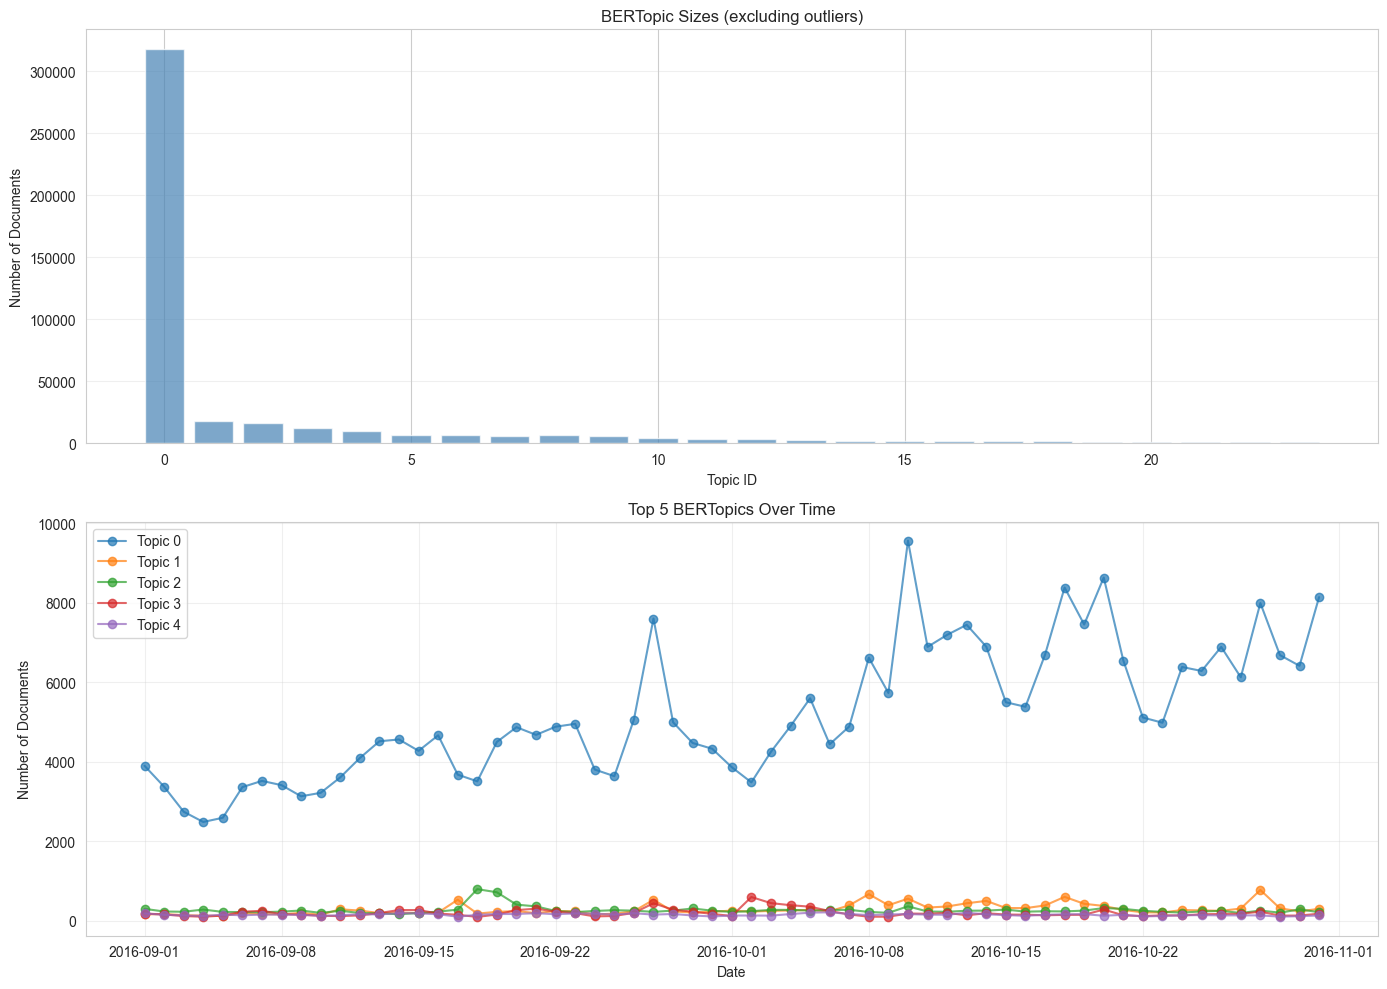

✓ Saved plot: bertopic_distribution.png


In [21]:
# Visualize topic sizes
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Topic sizes (excluding outliers)
topic_sizes = valid_topics['bertopic_id'].value_counts().sort_index()
axes[0].bar(topic_sizes.index, topic_sizes.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Topic ID')
axes[0].set_ylabel('Number of Documents')
axes[0].set_title('BERTopic Sizes (excluding outliers)')
axes[0].grid(alpha=0.3, axis='y')

# Topic distribution over time (top 5 topics)
topic_time = valid_topics.groupby(['date', 'bertopic_id']).size().reset_index(name='count')
top_5_topics = topic_sizes.nlargest(5).index

for topic_id in top_5_topics:
    topic_data = topic_time[topic_time['bertopic_id'] == topic_id]
    axes[1].plot(pd.to_datetime(topic_data['date']),
                 topic_data['count'],
                 marker='o',
                 label=f'Topic {topic_id}',
                 alpha=0.7)

axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Documents')
axes[1].set_title('Top 5 BERTopics Over Time')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_path / 'bertopic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved plot: bertopic_distribution.png")

## 6. Compare with STM/NMF Topics

Quick comparison of topic counts and outlier rates.

In [22]:
# Load STM results for comparison
stm_path = get_data_path('topics', 'reddit')
stm_thread_docs = read_parquet(stm_path / 'thread_pseudodocs_with_topics.parquet')

print("="*60)
print("COMPARISON: BERTopic vs STM/NMF")
print("="*60)
print(f"\nSTM/NMF (fixed K=25):")
print(f"  Topics: 25")
print(f"  Documents: {len(stm_thread_docs):,}")
print(f"  All documents assigned")

print(f"\nBERTopic (forced K={TARGET_TOPICS}):")
n_bertopics = len(set(topics)) - (1 if -1 in topics else 0)
print(f"  Topics: {n_bertopics}")
print(f"  Documents: {len(thread_docs):,}")
print(f"  All documents assigned (no outliers)")

print(f"\nApproach comparison:")
print(f"  STM/NMF: Fixed K upfront, probabilistic assignment")
print(f"  BERTopic: Auto-discovery → reduction to K={TARGET_TOPICS}, nearest-topic assignment")
print(f"\nBoth methods now produce {TARGET_TOPICS} topics for fair comparison")

COMPARISON: BERTopic vs STM/NMF

STM/NMF (fixed K=25):
  Topics: 25
  Documents: 433,973
  All documents assigned

BERTopic (forced K=25):
  Topics: 24
  Documents: 433,973
  All documents assigned (no outliers)

Approach comparison:
  STM/NMF: Fixed K upfront, probabilistic assignment
  BERTopic: Auto-discovery → reduction to K=25, nearest-topic assignment

Both methods now produce 25 topics for fair comparison


## 7. Save Model and Results

In [23]:
# Save BERTopic model
model_path = output_path / 'bertopic_model'
topic_model.save(str(model_path), serialization='safetensors', save_embedding_model=True)
print(f"✓ Saved BERTopic model: {model_path}")

✓ Saved BERTopic model: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/bertopic/bertopic_model


In [24]:
# Save topic summaries
topic_output = output_path / 'bertopic_summaries.parquet'
write_parquet(topic_summaries_df, topic_output)
print(f"✓ Saved topic summaries: {topic_output}")

✓ Wrote 24 rows to bertopic_summaries.parquet (0.0 MB)
✓ Saved topic summaries: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/bertopic/bertopic_summaries.parquet


In [25]:
# Save thread documents with BERTopic assignments
thread_output = output_path / 'thread_pseudodocs_with_bertopics.parquet'
write_parquet(thread_docs, thread_output)
print(f"✓ Saved thread documents with BERTopics: {thread_output}")
print(f"  Shape: {thread_docs.shape}")

✓ Wrote 433,973 rows to thread_pseudodocs_with_bertopics.parquet (1112.3 MB)
✓ Saved thread documents with BERTopics: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/bertopic/thread_pseudodocs_with_bertopics.parquet
  Shape: (433973, 15)


## 8. Model Metadata

In [27]:
# Create model metadata
model_metadata = {
    'notebook': '15a_reddit_bertopic_fit',
    'timestamp': datetime.now().isoformat(),
    'method': 'BERTopic',
    'model': {
        'algorithm': 'BERTopic',
        'embedding_model': 'all-MiniLM-L6-v2',
        'embedding_dims': 384,
        'device': device,
        'umap': {
            'n_neighbors': 15,
            'n_components': 5,
            'min_dist': 0.0,
            'metric': 'cosine'
        },
        'hdbscan': {
            'min_cluster_size': 300,
            'min_samples': 30,
            'metric': 'euclidean',
            'cluster_selection_method': 'eom'
        },
        'n_topics_discovered': int(n_bertopics),
        'n_topics_target': TARGET_TOPICS,
        'topic_reduction': 'forced_to_target',
        'outlier_handling': 'assign_to_nearest',
        'random_state': RANDOM_STATE,
        'use_sampling': USE_SAMPLING,
        'sample_fraction': SAMPLE_FRACTION if USE_SAMPLING else None
    },
    'vectorizer': {
        'type': 'CountVectorizer',
        'max_df': 0.5,
        'min_df': 5,
        'ngram_range': (1, 2),
        'stop_words': 'english'
    },
    'data': {
        'n_documents': len(thread_docs),
        'n_documents_with_topics': int((topics != -1).sum()),
        'n_outliers': int((topics == -1).sum()),
        'outlier_rate': float((topics == -1).mean())
    },
    'results': {
        'topics_discovered': int(n_bertopics),
        'mean_topic_size': float(topic_summaries_df['n_documents'].mean()),
        'median_topic_size': float(topic_summaries_df['n_documents'].median()),
        'largest_topic': int(topic_summaries_df['n_documents'].max()),
        'smallest_topic': int(topic_summaries_df['n_documents'].min())
    }
}

# Save metadata
metadata_file = output_path / 'bertopic_model_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("="*60)
print("BERTOPIC MODEL SUMMARY")
print("="*60)
print(f"\nMethod: {model_metadata['method']}")
print(f"Embedding: {model_metadata['model']['embedding_model']}")
print(f"Topics discovered: {model_metadata['model']['n_topics_discovered']}")
print(f"Documents: {model_metadata['data']['n_documents']:,}")
print(f"Documents with topics: {model_metadata['data']['n_documents_with_topics']:,}")
print(f"Outliers: {model_metadata['data']['n_outliers']:,} ({model_metadata['data']['outlier_rate']:.1%})")
print(f"\nMean topic size: {model_metadata['results']['mean_topic_size']:.0f}")
print(f"Median topic size: {model_metadata['results']['median_topic_size']:.0f}")

print(f"Smallest topic: {model_metadata['results']['smallest_topic']:,}")
print(f"Largest topic: {model_metadata['results']['largest_topic']:,}")
print(f"\nMetadata saved to: {metadata_file}")

BERTOPIC MODEL SUMMARY

Method: BERTopic
Embedding: all-MiniLM-L6-v2
Topics discovered: 24
Documents: 433,973
Documents with topics: 433,973
Outliers: 0 (0.0%)

Mean topic size: 18082
Median topic size: 3408
Smallest topic: 733
Largest topic: 317,953

Metadata saved to: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/bertopic/bertopic_model_metadata.json
